In [ ]:
from keras.applications import MobileNet
from keras import models
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras import optimizers

def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)

    return Model(inputs=input, outputs=predictions)

In [ ]:
model_maker.summary()

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
# Разархивируем датасета во временную папку 'temp'
!unzip -qo "cat-and-dog" -d ./temp

--2024-03-21 17:37:17--  https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228082266 (218M) [application/x-zip-compressed]
Saving to: ‘cat-and-dog.zip’

cat-and-dog.zip     100%[===================>] 217.52M  22.9MB/s    in 10s     

2024-03-21 17:37:28 (20.9 MB/s) - ‘cat-and-dog.zip’ saved [228082266/228082266]



In [ ]:
from keras.applications import MobileNet
conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
import os

# Набор утилит для работы с файловой системой
import shutil
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './temp/training_set/training_set/'

# Папка в которой будем создавать выборки
BASE_DIR = './dataset/'

# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# При повторном запуске пересоздаим структуру каталогов
# Если папка существует, то удаляем ее со всеми вложенными каталогами и файлами
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

# Создаем папку по пути BASE_DIR
os.mkdir(BASE_DIR)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + '/train'
train_dir = os.path.join(BASE_DIR, 'train')

# Создаем подпапку, используя путь
os.mkdir(train_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + '/validation'
validation_dir = os.path.join(BASE_DIR, 'validation')

# Создаем подпапку, используя путь
os.mkdir(validation_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + '/test'
test_dir = os.path.join(BASE_DIR, 'test')

# Создаем подпапку, используя путь
os.mkdir(test_dir)

def create_dataset(
    img_path: str,
    new_path: str,
    class_name: str,
    start_index: int,
    end_index: int):

    src_path = os.path.join(img_path, class_name)  # Полный путь к папке с изображениями класса
    dst_path = os.path.join(new_path, class_name)  # Полный путь к папке с новым датасетом класса

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(src_path)

    # Создаем подпапку, используя путь
    os.mkdir(dst_path)

    for fname in class_files[start_index : end_index]:
        src = os.path.join(src_path, fname)
        dst = os.path.join(dst_path, fname)
        shutil.copyfile(src, dst)

for class_label in range(CLASS_COUNT):    # Перебор по всем классам по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен

    create_dataset(IMAGE_PATH, train_dir, class_name, 0, 2000)
    create_dataset(IMAGE_PATH, validation_dir, class_name, 2000, 3000)
    create_dataset(IMAGE_PATH, test_dir, class_name, 3000, 4000)

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch

        # Преобразование labels_batch в одномерный массив
        labels_batch = np.argmax(labels_batch, axis=1)
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1

        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_dir, 4000)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 2000)

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
import numpy as np

train_features = np.reshape(train_features, (4000, 7 * 7 * 1024))
validation_features = np.reshape(validation_features, (2000, 7 * 7 * 1024))
test_features = np.reshape(test_features, (2000, 7 * 7 * 1024))

In [ ]:
from keras.applications import MobileNet
from keras import models
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from keras import optimizers
from keras.models import Model

IMG_WIDTH, IMG_HEIGHT = 224, 224

def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(class_name, activation='softmax')(custom_model)

    return Model(inputs=input, outputs=predictions)

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()

# Обратите внимание на размерность входа
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 1024))
model.add(layers.Dropout(0.5)) # Добавим прореживание для борьбы с переобучением
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_features, train_labels,
    epochs=10,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

# Оценка точности на тестовой выборке
score, acc = model.evaluate(test_features, test_labels, batch_size=batch_size)
print('Точность на тестовой выборке:', acc)

Epoch 1/10
200/200 [==============================] - 44s 216ms/step - loss: 0.1466 - acc: 0.9513 - val_loss: 0.0748 - val_acc: 0.9745
Epoch 2/10
200/200 [==============================] - 39s 196ms/step - loss: 0.0335 - acc: 0.9880 - val_loss: 0.0654 - val_acc: 0.9775
Epoch 3/10
200/200 [==============================] - 42s 209ms/step - loss: 0.0069 - acc: 0.9975 - val_loss: 0.0941 - val_acc: 0.9735
Epoch 4/10
200/200 [==============================] - 41s 203ms/step - loss: 0.0043 - acc: 0.9980 - val_loss: 0.0706 - val_acc: 0.9785
Epoch 5/10
200/200 [==============================] - 41s 204ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0785 - val_acc: 0.9790
Epoch 6/10
200/200 [==============================] - 41s 206ms/step - loss: 9.0216e-04 - acc: 1.0000 - val_loss: 0.0882 - val_acc: 0.9765
Epoch 7/10
200/200 [==============================] - 41s 204ms/step - loss: 5.7129e-04 - acc: 0.9998 - val_loss: 0.0826 - val_acc: 0.9790
Epoch 8/10
200/200 [===========================

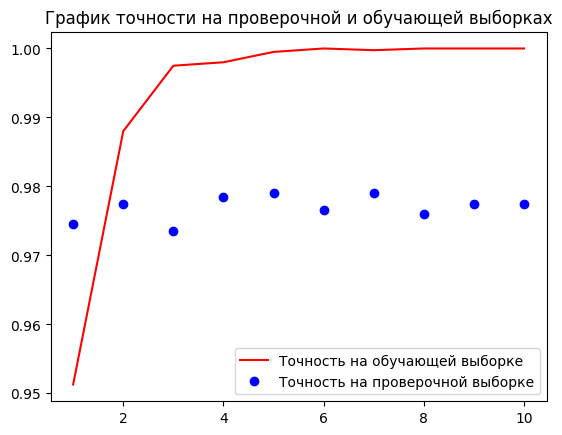

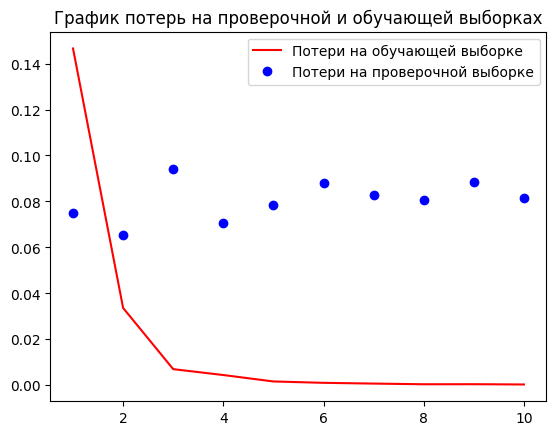

In [ ]:
import matplotlib.pyplot as plt

def show_history(store):
    acc = store.history['acc']
    val_acc = store.history['val_acc']
    loss = store.history['loss']
    val_loss = store.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')
    plt.title('График точности на проверочной и обучающей выборках')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'bo', label='Потери на проверочной выборке')
    plt.title('График потерь на проверочной и обучающей выборках')
    plt.legend()
    plt.show()

show_history(history)